In [98]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
from __future__ import division

import threading,time
import multiprocessing

from rtlsdr import RtlSdr
from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import serial

%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [136]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True, 
                     output_device_index=dev, frames_per_buffer=128)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,
                     frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig
            

def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
        

In [137]:
fs = 44100  # sampling rate
Ns = 20 # samples per bit
baud = float(fs)/Ns  # symbol rate
print(baud)

f_low = 1200.0
f_high = 2400.0

2205.0


In [138]:
Nbits = 10000  # number of bits
N = Nbits * Ns
bits = randn(Nbits) > 0

In [139]:
def afsk(bits, baud, fs=44100.0):
    Ns = int(float(fs) / baud)
    M = np.repeat(bits*2-1,Ns)
    
    f0 = (f_low + f_high) / 2.0
    delta_f = (f_high - f_low) / 2.0

    # compute phase by integrating frequency
    ph = 2*pi*cumsum(f0 + M.ravel()*delta_f)/fs
    FSK = sin(ph)

    return FSK
    
def nc_afsk_demod(sig, TBW=2.0, N=74,  fs = 44100.0):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZI (without rectifying it)

    BW =  float(TBW) / N
    
    h_mark = signal.firwin(numtaps=N, cutoff=BW) * np.exp(1j * 2 * pi * f_low/fs * arange(N))
    h_space = signal.firwin(numtaps=N, cutoff=BW) * np.exp(1j * 2 * pi * f_high/fs * arange(N))

    v_space = signal.fftconvolve(sig, h_space)
    v_mark  = signal.fftconvolve(sig, h_mark)

    NRZa = abs(v_space) - abs(v_mark)

    return NRZa[N/2:-N/2]

def decode_bits(x, fs=44100.0, baud=1200):
    NRZI = np.append([0], x)
    dNRZI = NRZI[1:] - NRZI[:-1]
    # find the position of the non-zero components. These are the indexes of the zero-crossings. 
    transit = nonzero(dNRZI)[0]
    # Transition time is the difference between zero-crossings
    transTime = transit[1:]-transit[:-1]
    
    state = (x[0] + 1) / 2.0
    
    samples_bit = float(fs) / baud
    
    bits = []
    
    for t in transTime:
        n = int(round(t / samples_bit + 0.05))
        if n > 0:
            bits.extend([state] * n)
        state = 1 - state
    
    return np.array(bits)

def decode_bits2(NRZI, fs=44100.0, baud=1200):

    samples_bit = float(fs) / baud
    
    offset = samples_bit / 2.0 
    i = offset
    
    n = 0
    
    bits = []
    
    while i < len(NRZI):
        bits.append(np.mean(NRZI[i:i+10]) > 0)
        n += 1
        i = int(n*samples_bit + offset)
    
    return np.array(bits) * 1.0


In [140]:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    t = r_[0.0:Npulse]/fs
    k = (f1 - f0) / max(t)
    f_of_t = f0 + k * t
    phi_of_t = cumsum(f_of_t) * 2 * pi * 1.0/fs
    s_chirp_a = exp(1j * phi_of_t)
    return s_chirp_a

def crossCorr( rcv, pulse_a ):
    return signal.fftconvolve(rcv, pulse_a[::-1], mode="full")

<Container object of 3 artists>

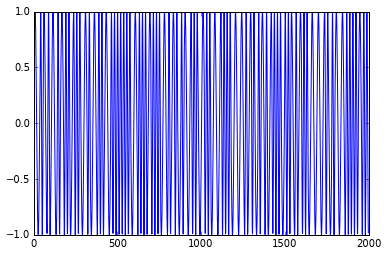

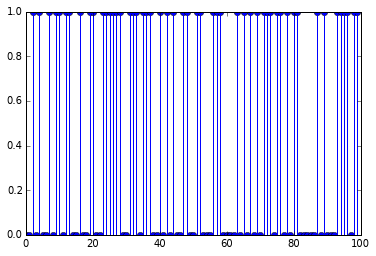

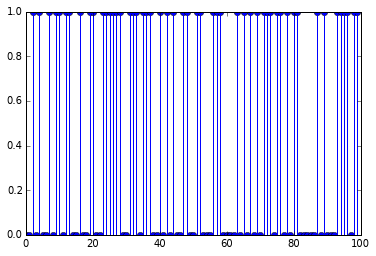

In [141]:
# test modulation and demodulation

figure()
sig = afsk(bits[:100], baud, fs)
plot(sig)
figure()
stem(np.int8(decode_bits2(np.sign(nc_afsk_demod(sig)), baud=baud)))
figure()
stem(np.int8(bits[:100]))

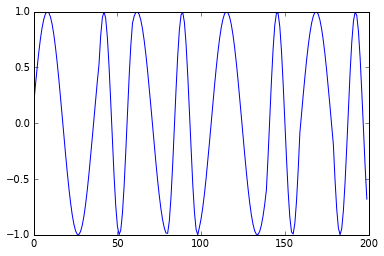

In [142]:
msg = afsk(1.0 * bits, baud, fs)
plot(msg[:200])

In [143]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
        
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 HDA NVidia: CS4206 Analog (hw:0,0)
1 HDA NVidia: CS4206 Digital (hw:0,1)
2 HDA NVidia: HDMI 0 (hw:0,3)
3 HDA NVidia: HDMI 0 (hw:0,7)
4 HDA NVidia: HDMI 0 (hw:0,8)
5 USB PnP Sound Device: Audio (hw:1,0)
6 sysdefault
7 front
8 surround21
9 surround40
10 surround51
11 surround71
12 iec958
13 spdif
14 hdmi
15 pulse
16 dmixout
17 dmix
18 default


In [144]:
# CHANGE!!!!
dusb_in = 5
dusb_out = 5
din = 0
dout = 0

In [145]:
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
else:                         #windows
    s = serial.Serial(port='/dev/ttyUSB0') ##### CHANGE !!!!!!
s.setDTR(0)

In [146]:
# sdr = RtlSdr()

In [147]:
#sdr.close()

In [148]:
t = r_[0:1*44100.0]/44100.0
sig2 = 0.5*sin(2*pi*500*t)
zero_sample = np.zeros(int(44100 * 1.0))

pulse = genChirpPulse(1600, 500.0, 3500.0, 44100.0)
pulse = pulse.real / 2.0

record_len = int((len(msg) + len(pulse) + len(zero_sample)) / float(fs)) + 2
if record_len % 2 != 0:
    record_len += 1

In [149]:
freq_offset = 83.2e3

sample_rate = 240e3
center_freq = 443.582e6 - freq_offset
#center_freq = 145.442e6 #- freq_offset

sdr.sample_rate = sample_rate  
sdr.center_freq = center_freq   
sdr.gain = 2

In [150]:
# creates a queue
Qout = Queue.Queue()

# initialize a serial port 
s.setDTR(0)
# create a pyaudio object
p = pyaudio.PyAudio()

t_play = threading.Thread(target = play_audio,   args = (Qout,   p, 44100, dusb_out, s ,0.2 ))

#Qout.put(sig2)
Qout.put("KEYON")
Qout.put(zero_sample)
Qout.put(pulse)
Qout.put(np.zeros(Ns*8))
Qout.put(msg)
Qout.put(np.zeros(1024))
Qout.put("KEYOFF")
Qout.put("EOT")

# play audio from Queue 
t_play.start()

N_samples = sample_rate*record_len # approximately seconds
sdr_samples = sdr.read_samples(N_samples)   # get samples

# must wait for the queue to empty before terminating pyaudio
while not(Qout.empty()) :
    time.sleep(1)
    

p.terminate()# kill a playing thread

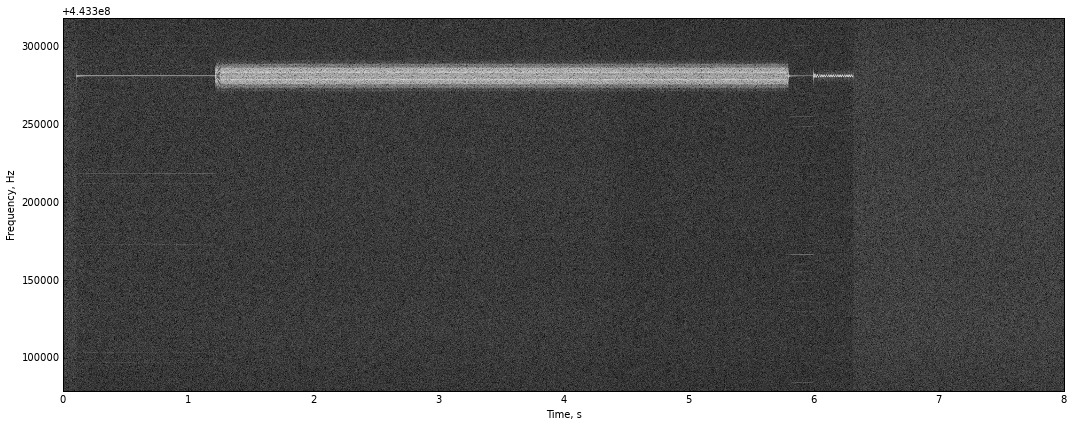

In [151]:
_ = myspectrogram_hann_ovlp(sdr_samples, 2048, sample_rate, center_freq)

1


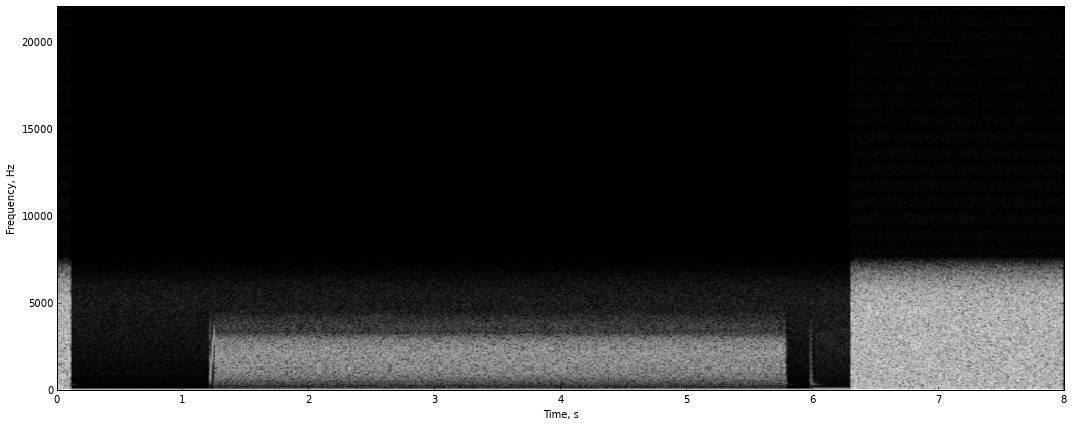

In [152]:
t = arange(len(sdr_samples)) / sample_rate
demod = exp(-2j*pi*freq_offset*t)
y = sdr_samples * demod

from scipy import signal  #should be imported already?

sig = angle(y[1:] * conj(y[:-1]))

h = signal.firwin(256,6000.0,nyq=sample_rate/2.0)
sigf = signal.fftconvolve(sig, h)

sigfd = sigf[::4]

fs = 44100.0
sigfdd = signal.resample(sigfd, len(sigfd) * float(fs) / (sample_rate / 4.0))

wsize = 1024
dbf = 20
ss = sigfdd
# ss = sigfd[35000:-8000]

figure()
_ = myspectrogram_hann_ovlp(ss, wsize, fs, 0, dbf)


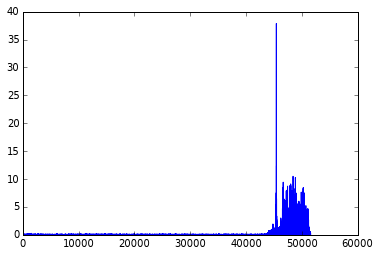

In [153]:
plot(abs(crossCorr(ss[10000:60000], pulse)))

In [154]:
p = np.argmax(crossCorr(ss[20000:60000], pulse))
start, end = 20000 + p+(Ns*8), 20000 + p+len(msg)+(Ns*8)
start, end

(55597, 255597)

In [155]:
pp = ss[start:end]

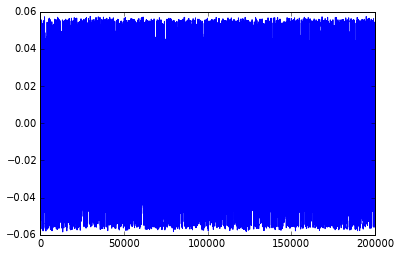

In [156]:
demod = nc_afsk_demod(pp, TBW=1.0)
demod = demod - np.mean(demod)
decoded = decode_bits2(np.sign(demod), baud=baud)

plot(demod)

In [159]:
import Levenshtein as leven

ds = ''.join([str(int(x)) for x in decoded])
bs = ''.join([str(int(x)) for x in bits])

dist = leven.distance(bs, ds)
print(dist)
print(100 * float(dist) / Nbits)
leven.editops(bs, ds)[:10]

401
4.01


[('replace', 6338, 6338),
 ('replace', 6375, 6375),
 ('replace', 6482, 6482),
 ('replace', 6498, 6498),
 ('replace', 6507, 6507),
 ('replace', 6548, 6548),
 ('replace', 6623, 6623),
 ('replace', 6684, 6684),
 ('replace', 6686, 6686),
 ('replace', 6701, 6701)]

(10000, 10000)


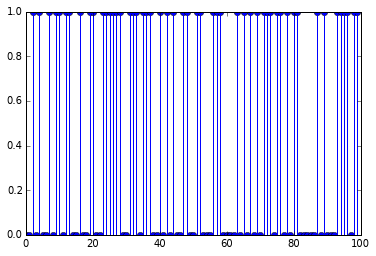

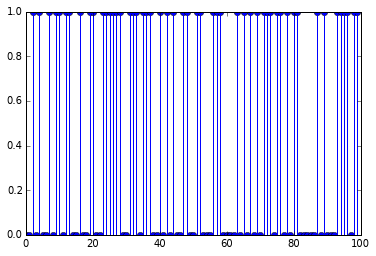

In [160]:
figure()
stem(decoded[:100])
figure()
stem(bits[:100])

print(len(decoded), len(bits))